In [1]:
%load_ext autoreload
%autoreload 1

import numpy as np
import os
import pickle
import time
import timeit
import json
import random

os.environ["DGLBACKEND"] = "pytorch"

import dgl
from dgl import from_networkx, node_subgraph

import torch as th
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight

import src.models as models
# from src.models import GRAPHSAGE, GAT, GCN
from src.dataset.dataset_info import datasets
from src.plot_confusion_matrix import plot_confusion_matrix
from src.calculate_FPR_FNR import calculate_FPR_FNR_with_global
from src.numpy_encoder import NumpyEncoder

# datasets = {dataset.name: dataset for dataset in datasets_list}

seed = 42  # or any constant value
random.seed(seed)
np.random.seed(seed)
th.manual_seed(seed)

%aimport src.models

num_epochs = 100
batch_size = 16
learning_rate = 0.001
LAMBD_1 = 0.0001
LAMBD_2 = 0.001


In [2]:
# name = "cic_ids_2017_5_percent"
# name = "cic_ton_iot_5_percent"
# name = "cic_ton_iot"
# name = "cic_ids_2017"
# name = "nf_bot_iot"
# name = "edge_iiot"
name = "nf_cse_cic_ids2018"
# name = "nf_bot_iotv2"
# name = "nf_uq_nids"
# name = "x_iiot"
# name = "cic_ton_iot_modified"
# name = "nf_ton_iotv2_modified"
# name = "ccd_inid_modified"
# name = "nf_uq_nids_modified"


with_centralities = False

validate = True
validate_epoch = 1

using_masking = False
masked_class = 2

multi_class = True

use_port_in_address = True
generated_ips = False

graph_type = "line"

window_size= 10000

sort_timestamp = False

dataset = datasets[name]

dataset_folder = os.path.join("datasets", name)
dataset_folder

'datasets\\nf_cse_cic_ids2018'

In [3]:
g_type = f"line_graph_{window_size}"

if multi_class:
    g_type += "__multi_class"
    
if with_centralities:
    g_type += "__n_feats"
    
# if k_fold:
#     g_type += f"__{k_fold}_fold"
    
if use_port_in_address:
    g_type += "__ports"
    
if generated_ips:
    g_type += "__generated_ips"
    
if sort_timestamp:
    g_type += "__sorted"
else:
    g_type += "__unsorted"
    
graphs_folder = os.path.join(dataset_folder, g_type)
graphs_folder

'datasets\\nf_cse_cic_ids2018\\line_graph_10000__multi_class__ports__unsorted'

In [4]:
number_neighbors = [25, 10]
# number_neighbors = None
num_layers = 2
ndim_out = [128, 128]
aggregation="mean"
# aggregation="pool"
# aggregation="lstm"
# aggregation="gcn"
activation=F.relu
dropout=0.2

my_models = [
    # models.LineGraphModel("gcn", models.GCN, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout),
    # models.LineGraphModel("graph_sage", models.GRAPHSAGE, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout, aggregator_type=aggregation),
    models.LineGraphModel("gat", models.GAT, num_layers=num_layers, ndim_out= ndim_out, activation=activation, dropout=dropout),
]

In [5]:
results_final = {}

results_final["name"] = name
results_final["g_type"] = g_type
results_final["configuration"] = {
    "num_epochs": num_epochs,
    "multi_class": multi_class,
    "batch_size": batch_size,
    "learning_rate": learning_rate,
    "num_neighbors": number_neighbors,
    "with_centralities": with_centralities,
    "using_masking": using_masking,
    "masked_class_num": masked_class,
    "LAMBD_2": LAMBD_2,
}

results_final["accuracy"] = {}
results_final["f1_score"] = {}
results_final["FPR"] = {}
results_final["FNR"] = {}
results_final["time_elapsed"] = {}
results_final["train_accuracy"] = {}
results_final["train_loss"] = {}
results_final["val_accuracy"] = {}
results_final["val_loss"] = {}
results_final["val_precision"] = {}
results_final["val_recall"] = {}
results_final["val_f1"] = {}
results_final["val_FPR"] = {}
results_final["val_FNR"] = {}

for m in my_models:
    results_final[m.model_name] = {}
    results_final["accuracy"][m.model_name] = []
    results_final["time_elapsed"][m.model_name] = []
    results_final["train_accuracy"][m.model_name] = []
    results_final["train_loss"][m.model_name] = []
    results_final["val_accuracy"][m.model_name] = []
    results_final["val_loss"][m.model_name] = []
    results_final["val_precision"][m.model_name] = []
    results_final["val_recall"][m.model_name] = []
    results_final["val_f1"][m.model_name] = []
    results_final["val_FPR"][m.model_name] = []
    results_final["val_FNR"][m.model_name] = []

results_final

{'name': 'nf_cse_cic_ids2018',
 'g_type': 'line_graph_10000__multi_class__ports__unsorted',
 'configuration': {'num_epochs': 100,
  'multi_class': True,
  'batch_size': 16,
  'learning_rate': 0.001,
  'num_neighbors': [25, 10],
  'with_centralities': False,
  'using_masking': False,
  'masked_class_num': 2,
  'LAMBD_2': 0.001},
 'accuracy': {'gat': []},
 'f1_score': {},
 'FPR': {},
 'FNR': {},
 'time_elapsed': {'gat': []},
 'train_accuracy': {'gat': []},
 'train_loss': {'gat': []},
 'val_accuracy': {'gat': []},
 'val_loss': {'gat': []},
 'val_precision': {'gat': []},
 'val_recall': {'gat': []},
 'val_f1': {'gat': []},
 'val_FPR': {'gat': []},
 'val_FNR': {'gat': []},
 'gat': {}}

In [6]:
dtime = time.strftime("%Y%m%d-%H%M%S")
dtime

'20250128-112616'

In [7]:
results_folder_path = "results"
results_folder_path1 = os.path.join(results_folder_path, name)
results_folder_path2 = os.path.join(results_folder_path1, g_type)
folder_path = os.path.join(results_folder_path2, dtime)
confusion_matrices_path = os.path.join(folder_path, "confusion_matrices")
os.makedirs(confusion_matrices_path, exist_ok=True)
os.makedirs("temp", exist_ok=True)
# os.makedirs(confusion_matrices_path, exist_ok=True)

In [8]:
labels = ["Normal", "Attack"]
num_classes = 2
if multi_class:
    with open(os.path.join(dataset_folder, "labels_names.pkl"), "rb") as f:
        labels_names = pickle.load(f)
    labels_mapping = labels_names[0]
    # labels = labels_names[1]
    labels = list(labels_mapping.values())
    num_classes = len(labels)
labels, num_classes

([np.str_('Benign'),
  np.str_('Bot'),
  np.str_('Brute Force -Web'),
  np.str_('Brute Force -XSS'),
  np.str_('DDOS attack-HOIC'),
  np.str_('DDOS attack-LOIC-UDP'),
  np.str_('DDoS attacks-LOIC-HTTP'),
  np.str_('DoS attacks-GoldenEye'),
  np.str_('DoS attacks-Hulk'),
  np.str_('DoS attacks-SlowHTTPTest'),
  np.str_('DoS attacks-Slowloris'),
  np.str_('FTP-BruteForce'),
  np.str_('Infilteration'),
  np.str_('SQL Injection'),
  np.str_('SSH-Bruteforce')],
 15)

In [9]:
if using_masking:
    results_final["configuration"]["masked_class_name"] = str(labels[masked_class])

In [10]:
dataset_folder_path = None
dataset_folder_path_train = os.path.join(graphs_folder, "training", "graphs")
dataset_folder_path_val = os.path.join(graphs_folder, "validation", "graphs")
dataset_folder_path_test = os.path.join(graphs_folder, "testing", "graphs")

In [11]:
node_attrs = ['h', dataset.label_col, dataset.class_num_col]
# node_attrs = ['h', dataset.label_col, dataset.class_num_col, "index"]
# read training, validation, and testing graphs
if dataset_folder_path:
    graphs = []
    for file in os.listdir(dataset_folder_path):
        # print(f"==>> file: {os.path.join(dataset_folder_path_train, file)}")
        with open(os.path.join(dataset_folder_path, file), "rb") as f:
            G = pickle.load(f)
            # print(list(G.nodes(data=True))[0])
            G = from_networkx(G,node_attrs=node_attrs)
            node_label = G.ndata[dataset.label_col]
            # if len(node_label.unique()) > 1:
            #     print(f"==>> node_label.unique(): {len(node_label.unique())}")
                
            graphs.append(G)

            # break
            
    training_graphs, testing_graphs = train_test_split(graphs, test_size=0.2, random_state=42)
    len(training_graphs)

In [12]:
if dataset_folder_path_train:
    training_graphs = []
    training_labels = []
    for file in os.listdir(dataset_folder_path_train):
        with open(os.path.join(dataset_folder_path_train, file), "rb") as f:
            G = pickle.load(f)
            # print(list(G.nodes(data=True))[0])
            G = from_networkx(G,node_attrs=node_attrs)

            if using_masking:
                training_mask = G.ndata[dataset.class_num_col] != masked_class
                G = node_subgraph(G, training_mask)
                
            if multi_class:
                node_labels = G.ndata[dataset.class_num_col]
            else:
                node_labels = G.ndata[dataset.label_col]
                
            training_graphs.append(G)
            training_labels.append(node_labels)
    len(training_graphs)

In [13]:
if dataset_folder_path_val:
    validation_graphs = []
    for file in os.listdir(dataset_folder_path_val):
        with open(os.path.join(dataset_folder_path_val, file), "rb") as f:
            G = pickle.load(f)
            G = from_networkx(G,node_attrs=node_attrs)
            validation_graphs.append(G)
    len(validation_graphs)

In [14]:
if dataset_folder_path_test:
    testing_graphs = []
    for file in os.listdir(dataset_folder_path_test):
        with open(os.path.join(dataset_folder_path_test, file), "rb") as f:
            G = pickle.load(f)
            G = from_networkx(G,node_attrs=node_attrs)
            testing_graphs.append(G)
    len(testing_graphs)

In [15]:
G0 = training_graphs[0]
num_features = G.ndata['h'].shape[1]

In [16]:
concat_training_labels = th.cat(training_labels).numpy()

In [17]:
class_weights = class_weight.compute_class_weight('balanced',
                                                classes=np.unique(concat_training_labels),
                                                y=concat_training_labels)

In [18]:
if using_masking:
    class_weights=np.insert(class_weights, masked_class, 0)

In [19]:
class_weights = th.FloatTensor(class_weights)

criterion = nn.CrossEntropyLoss(weight=class_weights)

In [20]:
def compute_accuracy(pred, labels):
    # return (pred == labels).float().mean().item()
    correct = 0
    total = len(labels)
    # Count correct predictions
    correct = np.sum(np.array(pred) == np.array(labels))

    # Compute accuracy
    accuracy = correct / total if total > 0 else 0
    return accuracy


In [21]:
class GraphDataset(th.utils.data.Dataset):
    def __init__(self, graphs):
        self.graphs = graphs

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx]

In [22]:
train_dataset = GraphDataset(training_graphs)
val_dataset = GraphDataset(validation_graphs)
test_dataset = GraphDataset(testing_graphs)

In [23]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=dgl.batch)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=dgl.batch)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=dgl.batch)

In [24]:
def evaluate_model(model, loader, labels, results_f, epoch, loss_fn, model_name):
    start_time = timeit.default_timer()
    model.eval()
    all_preds = []
    all_labels = []
    
    total_val_loss = 0.0
    total_samples = 0
    with th.no_grad():
        for batched_graph in loader:
            features = batched_graph.ndata['h']
            labels_batch = batched_graph.ndata[dataset.class_num_col if multi_class else dataset.label_col]
            logits = model(batched_graph, features)
            loss = loss_fn(logits, labels_batch)
            
            this_batch_size = labels_batch.size(0)
            total_val_loss += loss.item() * this_batch_size
            total_samples += this_batch_size
            
            preds = th.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
    
    elapsed = timeit.default_timer() - start_time
    val_loss = total_val_loss / total_samples if total_samples > 0 else 0.0
    # print(f"Time for validation: {elapsed:.4f}")
    # Compute metrics
    actual = all_labels
    test_pred = all_preds
    
    if multi_class:
        actual = np.vectorize(labels_names[0].get)(actual)
        test_pred = np.vectorize(labels_names[0].get)(test_pred)
    else:
        actual = ["Normal" if i == 0 else "Attack" for i in actual]
        test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    cr = classification_report(actual, test_pred, digits=4, output_dict=True, zero_division=0)
    
    val_acc = cr["accuracy"] * 100
    val_precision = cr['weighted avg']['precision'] * 100
    val_recall = cr['weighted avg']['recall'] * 100
    val_f1 = cr['weighted avg']['f1-score'] * 100
    cm = confusion_matrix(actual, test_pred, labels=labels)

    results_fpr_fnr = calculate_FPR_FNR_with_global(cm)
    
    # Log metrics
    results_f["val_accuracy"][model_name].append(val_acc)
    results_f["val_loss"][model_name].append(val_loss)
    results_f["val_precision"][model_name].append(val_precision)
    results_f["val_recall"][model_name].append(val_recall)
    results_f["val_f1"][model_name].append(val_f1)
    results_f["val_FPR"][model_name].append(results_fpr_fnr["global"]["FPR"])
    results_f["val_FNR"][model_name].append(results_fpr_fnr["global"]["FNR"])

    return val_acc, val_loss, elapsed


In [25]:
def train_model(line_graph_model: models.LineGraphModel, train_loader, val_loader, num_epochs, lr):
    
    if line_graph_model.model_class == models.GRAPHSAGE:
        line_graph_model.training_model = line_graph_model.model_class(num_features, ndim_out=line_graph_model.ndim_out, aggregator_type = line_graph_model.aggregator_type, n_classes=num_classes)
        line_graph_model.best_model = line_graph_model.model_class(num_features, ndim_out=line_graph_model.ndim_out, aggregator_type = line_graph_model.aggregator_type, n_classes=num_classes)
    else:
        line_graph_model.training_model = line_graph_model.model_class(num_features, ndim_out=line_graph_model.ndim_out, n_classes=num_classes)
        line_graph_model.best_model = line_graph_model.model_class(num_features, ndim_out=line_graph_model.ndim_out, n_classes=num_classes)
        
    optimizer = th.optim.Adam(line_graph_model.training_model.parameters(), lr=lr, weight_decay=LAMBD_2)
    loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    # if multi_class:
    #     loss_fn = nn.CrossEntropyLoss(weight=class_weights)
    # else:
    #     loss_fn = nn.BCEWithLogitsLoss(weight=class_weights)
    best_val_acc = 0

    print("================================")
    print("================================")
    print(f"Training Model: {line_graph_model.model_name}")
    
    for epoch in range(num_epochs):
        
        all_training_preds = []
        all_training_labels = []
    
        total_train_loss = 0.0
        total_samples = 0
    
        line_graph_model.training_model.train()
        for batched_graph in train_loader:
            features = batched_graph.ndata['h']
            actual_labels = batched_graph.ndata[dataset.class_num_col if multi_class else dataset.label_col]

            logits = line_graph_model.training_model(batched_graph, features)
            loss = loss_fn(logits, actual_labels)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            this_batch_size = actual_labels.size(0)
            total_train_loss += loss.item() * this_batch_size
            total_samples += this_batch_size
            
            preds = th.argmax(logits, dim=-1)
            all_training_preds.extend(preds.cpu().numpy())
            all_training_labels.extend(actual_labels.cpu().numpy())
        
        pred = all_training_preds
        actual_labels = all_training_labels
        train_acc = compute_accuracy(pred, actual_labels)  * 100
        train_loss = total_train_loss / total_samples if total_samples > 0 else 0.0
        # print("Model: {} -- Epoch: {} -- Training acc: {:.5f}".format(line_graph_model.model_name, epoch, compute_accuracy(pred, actual_labels)))
        print(f"Model: {line_graph_model.model_name} -- Epoch: {epoch} -- Training acc: {train_acc:.2f} -- Training loss: {train_loss:.4f}")
        results_final["train_accuracy"][line_graph_model.model_name].append(train_acc)
        results_final["train_loss"][line_graph_model.model_name].append(train_loss)
        
        # Validation step
        val_acc, val_loss, elapsed = evaluate_model(
            line_graph_model.training_model, 
            val_loader, 
            labels, 
            results_final, 
            epoch,
            loss_fn = loss_fn,
            model_name=line_graph_model.model_name
        )
        print(f"Model: {line_graph_model.model_name} -- Epoch: {epoch} -- Validation acc: {val_acc:.2f} -- Validation loss: {val_loss:.4f}")
        print(f"Time for validation: {elapsed:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = line_graph_model.training_model.state_dict().copy()
            # th.save(best_model_state, f"temp/best_model_{line_graph_model.model_name}.pth")
            th.save(line_graph_model.training_model, f"temp/best_model_{line_graph_model.model_name}.pth")
            
    line_graph_model.best_model.load_state_dict(best_model_state)


In [26]:
def test_model(model, loader, labels, model_name, results_f):
    print("=======================")
    print(f"testing model: {model_name}")

    start_time = timeit.default_timer()
    
    # Run evaluation
    all_preds = []
    all_labels = []
    
    model.eval()
    with th.no_grad():
        for batched_graph in loader:
            features = batched_graph.ndata['h']
            labels_batch = batched_graph.ndata[dataset.class_num_col if multi_class else dataset.label_col]  # Adjust to 'class' for multi-class
            logits = model(batched_graph, features)
            preds = th.argmax(logits, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels_batch.cpu().numpy())
    
    elapsed = timeit.default_timer() - start_time
    # Compute metrics
    actual = all_labels
    test_pred = all_preds
    
    
    if multi_class:
        actual = np.vectorize(labels_names[0].get)(actual)
        test_pred = np.vectorize(labels_names[0].get)(test_pred)
    else:
        actual = ["Normal" if i == 0 else "Attack" for i in actual]
        test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

    cr = classification_report(actual, test_pred, digits=4, output_dict=True, zero_division=0)

    cm = confusion_matrix(actual, test_pred, labels=labels)
    cm_normalized = confusion_matrix(actual, test_pred, labels=labels, normalize="true")
    results_fpr_fnr = calculate_FPR_FNR_with_global(cm)


    # Log metrics
    results_f[model_name]["elapsed"] = elapsed
    results_f[model_name]["classification_report"] = cr
    results_f[model_name]["results_fpr_fnr"] = results_fpr_fnr
    results_f["accuracy"][model_name] = cr["accuracy"] * 100
    results_f["f1_score"][model_name] = cr['weighted avg']['f1-score'] * 100
    results_f["FPR"][model_name] = results_fpr_fnr["global"]["FPR"]
    results_f["FNR"][model_name] = results_fpr_fnr["global"]["FNR"]
    results_f["time_elapsed"][model_name] = elapsed


    print(classification_report(actual, test_pred, digits=4, zero_division=0))
    
    return actual, test_pred, cm, cm_normalized


### Training GNN models

In [27]:
# %autoreload

In [28]:
for m in my_models:
    train_model(m, train_loader, val_loader, num_epochs, learning_rate)
    # cm = test_model(m, G_test, test_labels, results_final, labels)
    actual, test_pred, cm, cm_normalized = test_model(m.best_model, test_loader, labels, m.model_name, results_final)
    plot_confusion_matrix(cm=cm,
                          normalize=False,
                          target_names=labels,
                          title=f"Confusion Matrix of {m.model_name}",
                          file_path=f"{confusion_matrices_path}/{m.model_name}.png")
    
    plot_confusion_matrix(cm=cm_normalized,
                          normalize=False,
                          normalized=True,
                          target_names=labels,
                          title=f"Normalized Confusion Matrix of {m.model_name}",
                          file_path=f"{confusion_matrices_path}/{m.model_name}_normalized.png")
    
    with open(os.path.join(folder_path, "actual.json"), "w") as f:
        f.writelines(json.dumps(actual, cls=NumpyEncoder))
        
    with open(os.path.join(folder_path, f"{m.model_name}_pred.json"), "w") as f:
        f.writelines(json.dumps(test_pred, cls=NumpyEncoder))
        
    with open(os.path.join(folder_path, "results.json"), "w") as f:
        f.writelines(json.dumps(results_final, cls=NumpyEncoder))

In [29]:

# import importlib.util
# import sys
# def add_lib(module_name, path):
#     spec = importlib.util.spec_from_file_location(module_name, path)
#     dataset_info = importlib.util.module_from_spec(spec)
#     sys.modules[module_name] = dataset_info
#     spec.loader.exec_module(dataset_info)

# add_lib("gat", "C:/Users/Administrateur/Desktop/GNN-NIDS/src/models/gat.py")


C:\Users\Administrateur\AppData\Local\Temp\3\ipykernel_13860\1217023612.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.best_model = th.load(f"temp/best_model_{m.model

testing model: gat
                          precision    recall  f1-score   support

                  Benign     0.9960    0.5362    0.6971    668289
                     Bot     0.9748    1.0000    0.9873      1550
        Brute Force -Web     0.0794    0.2941    0.1250        17
        Brute Force -XSS     0.0092    0.7000    0.0182        10
        DDOS attack-HOIC     0.0000    0.0000    0.0000        23
    DDOS attack-LOIC-UDP     0.7466    0.9880    0.8505       167
  DDoS attacks-LOIC-HTTP     0.8708    0.9967    0.9295     29736
   DoS attacks-GoldenEye     0.3455    0.6403    0.4488      3258
        DoS attacks-Hulk     0.8519    0.8003    0.8253     10813
DoS attacks-SlowHTTPTest     0.0524    1.0000    0.0996      1412
   DoS attacks-Slowloris     0.4295    0.8521    0.5711      1711
          FTP-BruteForce     0.0000    0.0000    0.0000      1412
           Infilteration     0.0171    0.7336    0.0334      5950
           SQL Injection     0.0002    1.0000    0.0004 

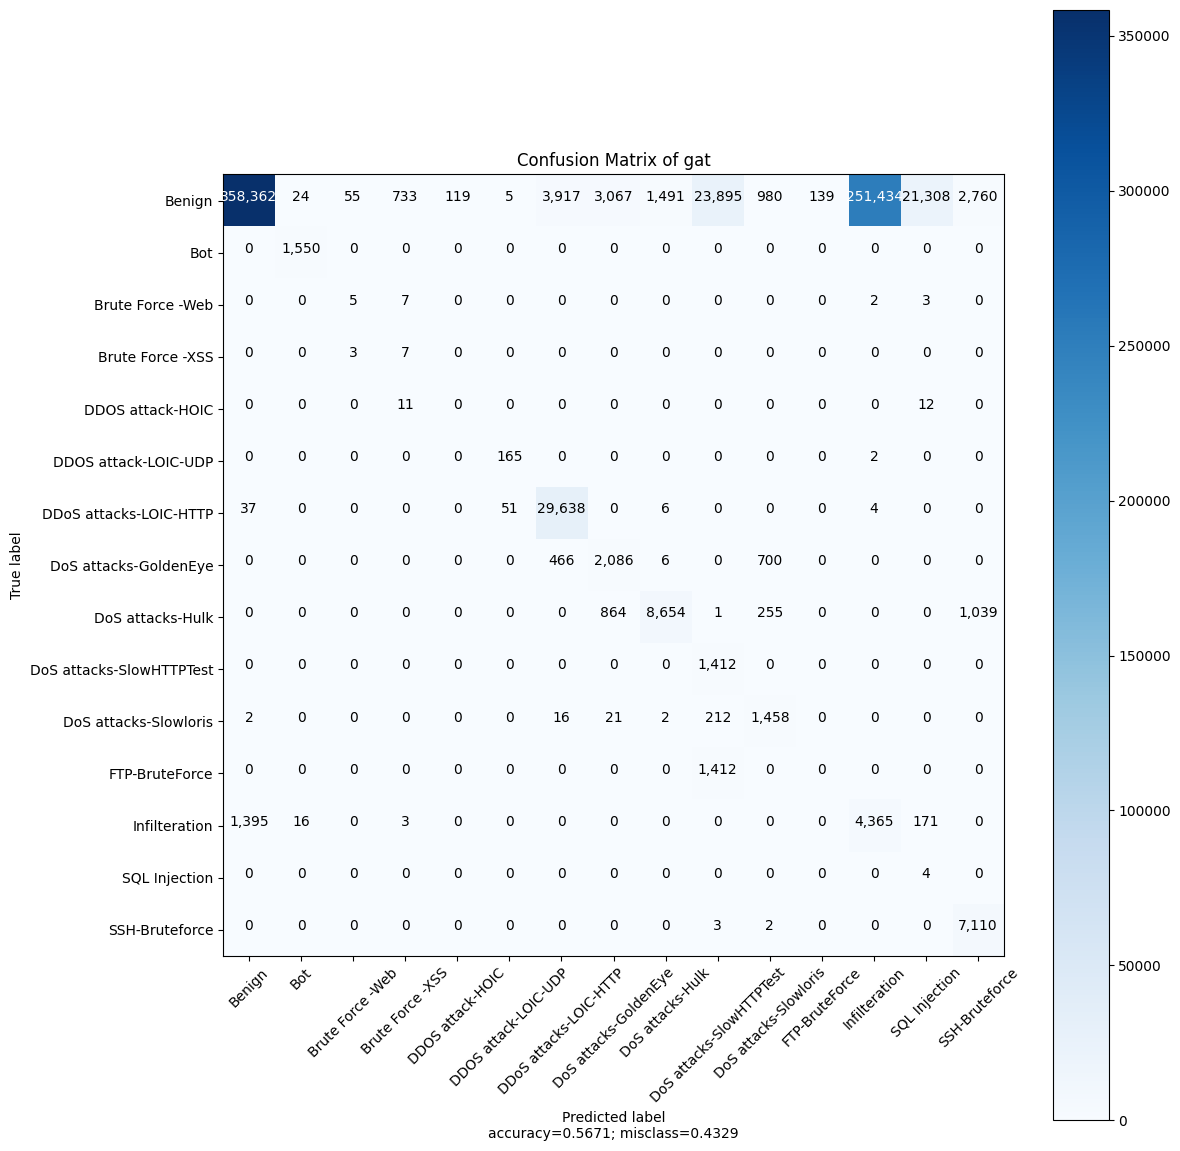

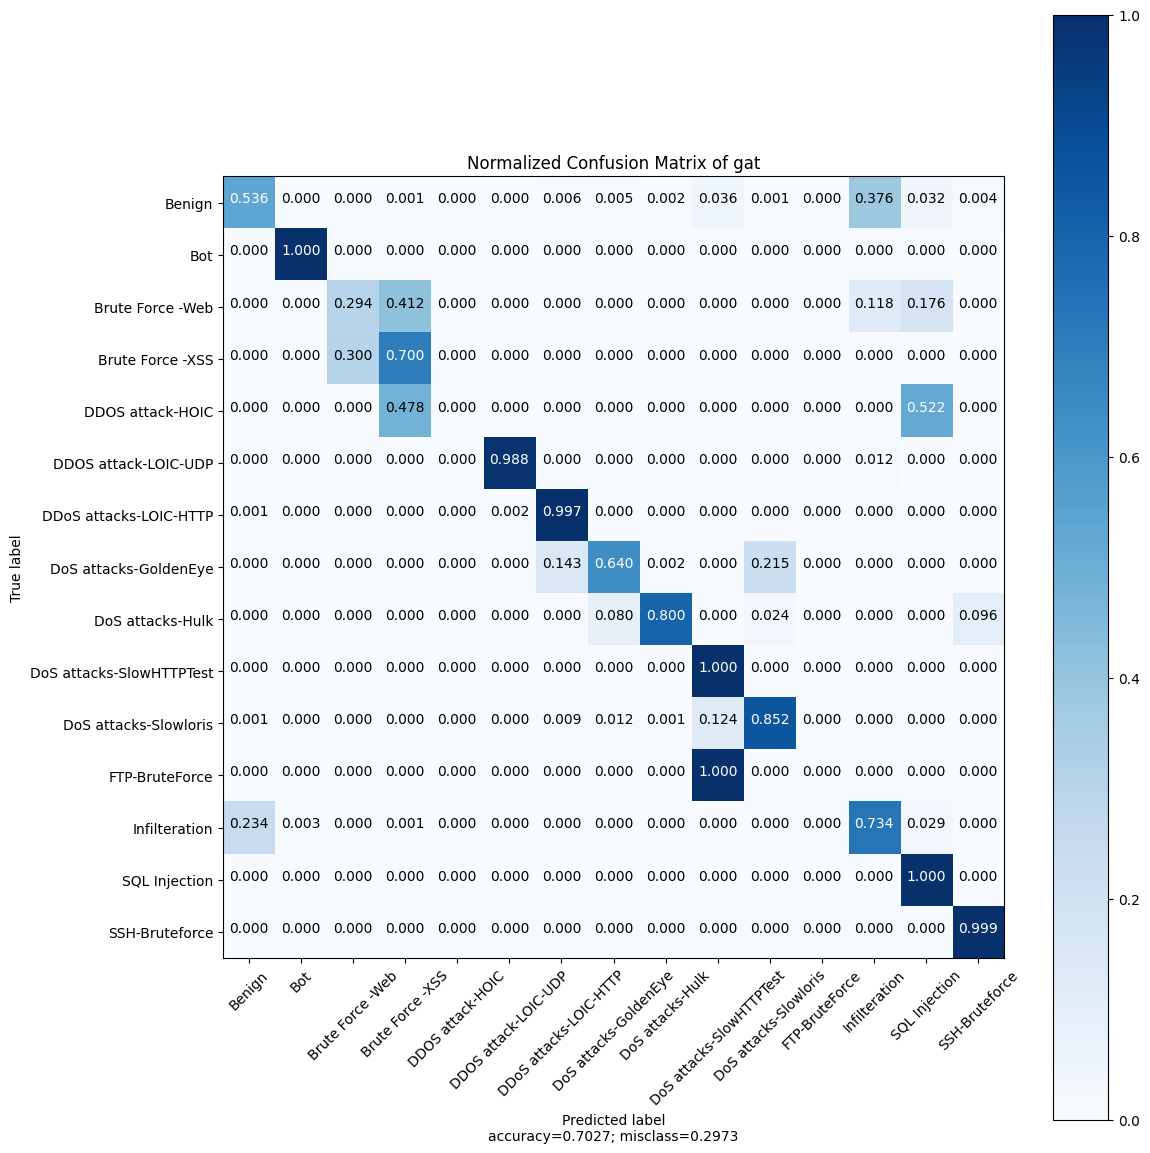

In [30]:
# for m in my_models:
#     m.best_model = th.load(f"temp/best_model_{m.model_name}.pth")
        
#     # cm = test_model(m, G_test, test_labels, results_final, labels)
#     actual, test_pred, cm, cm_normalized = test_model(m.best_model, test_loader, labels, m.model_name, results_final)
#     plot_confusion_matrix(cm=cm,
#                           normalize=False,
#                           target_names=labels,
#                           title=f"Confusion Matrix of {m.model_name}",
#                           file_path=f"{confusion_matrices_path}/{m.model_name}.png")
    
#     plot_confusion_matrix(cm=cm_normalized,
#                           normalize=False,
#                           normalized=True,
#                           target_names=labels,
#                           title=f"Normalized Confusion Matrix of {m.model_name}",
#                           file_path=f"{confusion_matrices_path}/{m.model_name}_normalized.png")
    
#     with open(os.path.join(folder_path, "actual.json"), "w") as f:
#         f.writelines(json.dumps(actual, cls=NumpyEncoder))
        
#     with open(os.path.join(folder_path, f"{m.model_name}_pred.json"), "w") as f:
#         f.writelines(json.dumps(test_pred, cls=NumpyEncoder))
        
#     with open(os.path.join(folder_path, "results.json"), "w") as f:
#         f.writelines(json.dumps(results_final, cls=NumpyEncoder))